In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [39]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

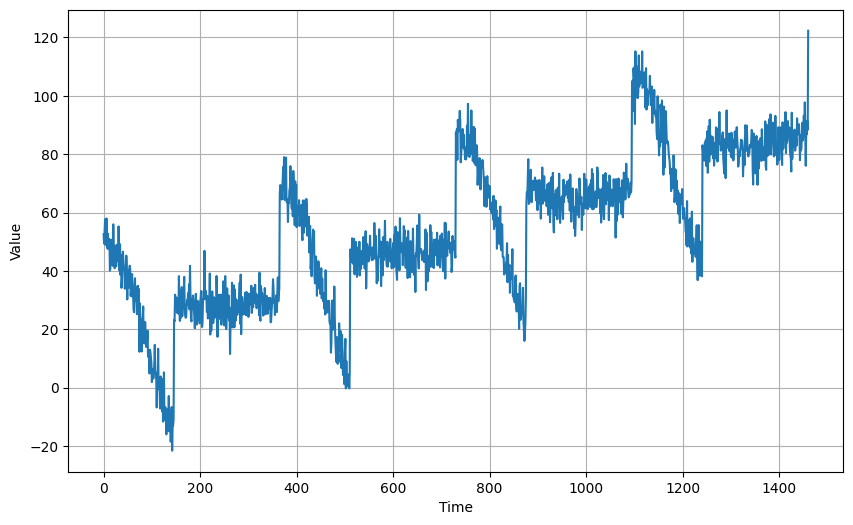

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [4]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size)

    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)

    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [8]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20, 1)
shape of label: (32, 1)


#Build the Model-RNN

Your model is composed mainly of SimpleRNN layers. As mentioned in the lectures, this type of RNN simply routes its output back to the input. You will stack two of these layers in your model so the first one should have return_sequences set to True.

Normally, you can just have a Dense layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the activation functions you used in your model. SimpleRNN uses tanh by default and that has an output range of [-1,1]. You will use a Lambda layer to scale the output by 100 before it adjusts the layer weights. Lambda layers can be a useful tool to experiment with simple transformations like this. Feel free to remove this layer later after this lab and see what results you get.

In [10]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 20, 40)              │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 40)                  │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              41 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,961 (19.38 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

##Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the Huber Loss as your loss function to minimize sensitivity to outliers.

In [11]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 147.1120 - learning_rate: 1.0000e-08
Epoch 2/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 139.5467

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 138.8679 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 130.6586 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 123.2399 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 115.9261 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 108.1190 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 99.6131 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 90.9667 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 82.8532 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 75.4089 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68.4409 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - l

(1e-08, 0.001, 0.0, 50.0)

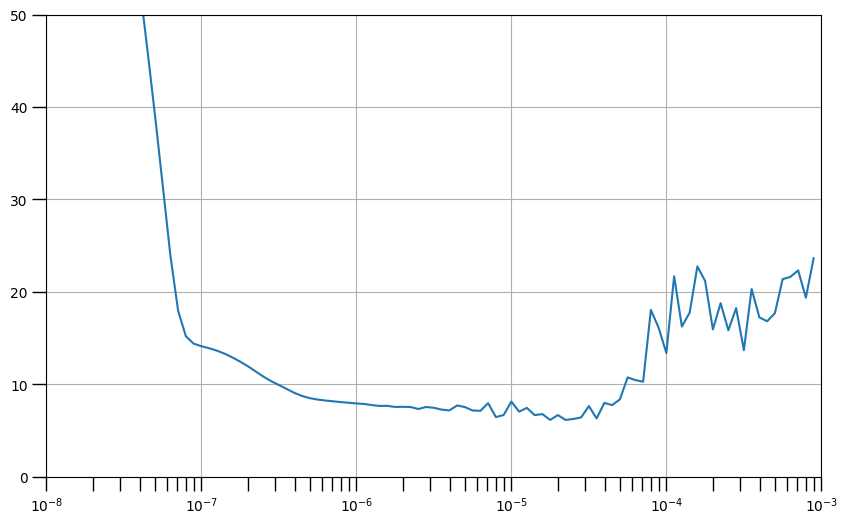

In [12]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

(1e-07, 0.0001, 0.0, 20.0)

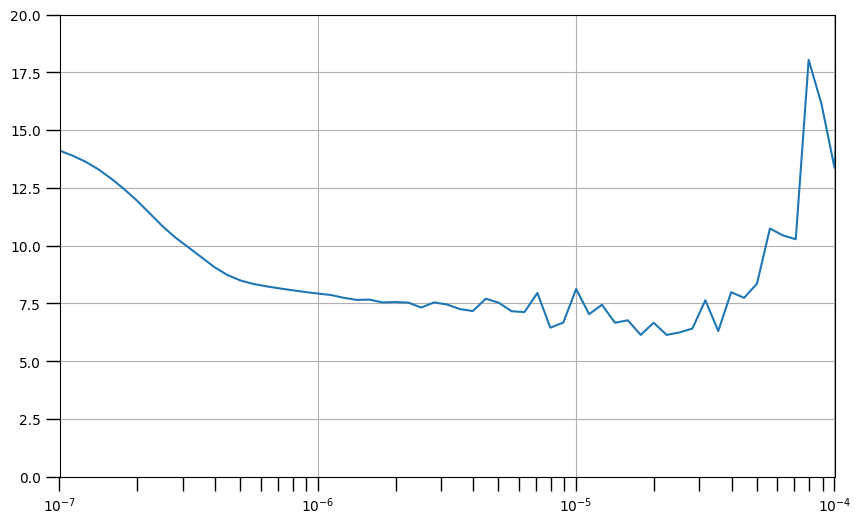

In [13]:
#You can change the boundaries of the graph if you want to zoom in.
#The cell below chooses a narrower range so you can see more clearly where the graph becomes unstable.

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

##Train the Model

You can then declare the model again and train with the learning rate you picked. It is set to 1e-6by default but feel free to change it.

In [14]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 133.3661 - mae: 133.8661
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21.7950 - mae: 22.2919
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.0417 - mae: 14.5338
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.0779 - mae: 11.5655
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9883 - mae: 8.4732
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2125 - mae: 7.6936
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8763 - mae: 7.3567
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6763 - mae: 7.1580
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5121 - mae: 6.9923
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3781 - mae: 6.8573
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2708 - mae: 6.7498
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1826 - mae: 6.6607
Epoch 13/100
31/31 ━━━━━━━

##Model Prediction

Now it's time to generate the model predictions for the validation set time range. The model is a lot bigger than the ones you used before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow. You can observe this when using the code you ran in the previous lab. This will take about a minute to complete.

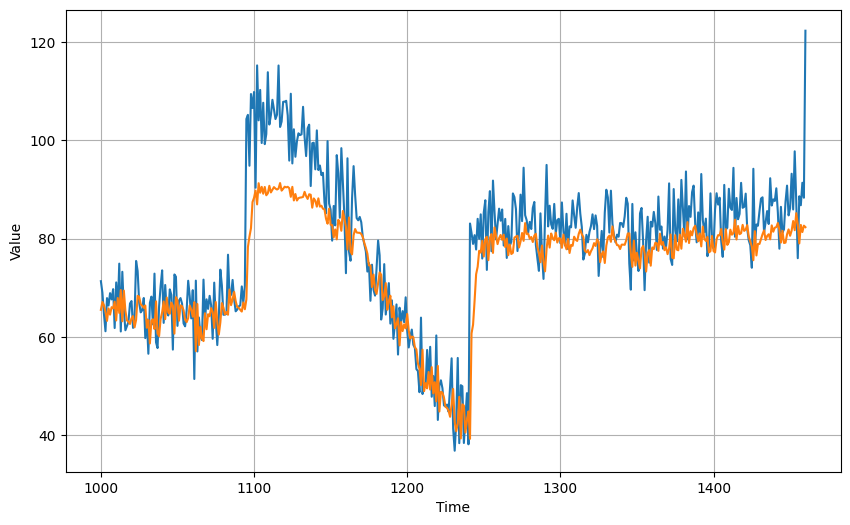

In [15]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, you can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. You will notice that it almost mirrors the windowed_dataset() function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.

In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)

    return forecast

In [19]:
#can run the function below to use the function. Notice that the predictions are generated almost instantly.

# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [20]:
# Compute the MSE and MAE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

74.4028
6.340756


#Build a LSTM model

In [21]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 20, 64)              │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 96.8614 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 95.7415 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 94.2275 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 92.3953 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 90.1264 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 87.2968 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 84.0317 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 80.7866 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 77.7560 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 74.7824 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 71.6686 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 

(1e-08, 0.001, 0.0, 30.0)

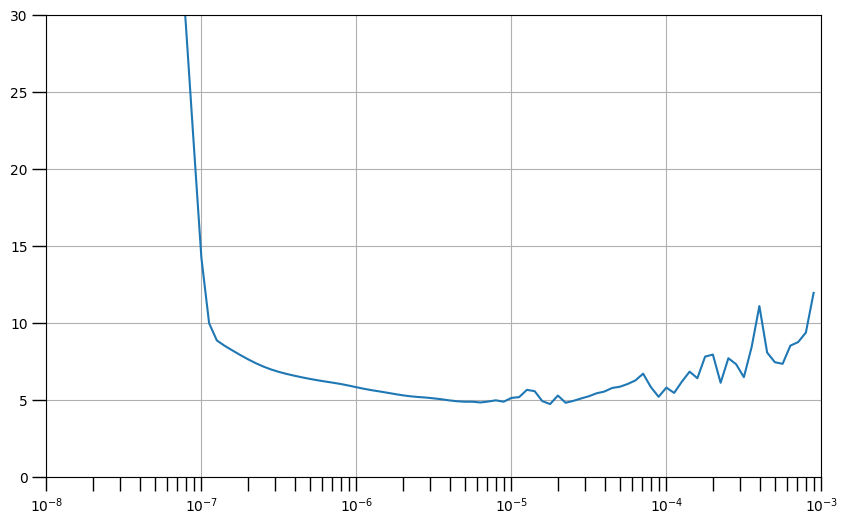

In [23]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

##Train the Model

You can then proceed to train the model with your chosen learning rate.

Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the clear_session() method to declutter memory used by Keras. This is added in the first line below.

In [24]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 22.0918 - mae: 22.5886
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.7549 - mae: 11.2430
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4917 - mae: 6.9741
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0128 - mae: 6.4921
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6781 - mae: 6.1582
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4380 - mae: 5.9132
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2164 - mae: 5.6971
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0784 - mae: 5.5553
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9911 - mae: 5.4716
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9330 - mae: 5.4112
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8919 - mae: 5.3638
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8451 - mae: 5.3186
Epoch 13/100
31/31 ━━━━━━━━━━━━━━

##Model Prediction

You will then generate batches of windows to generate predictions that align with the validation set.

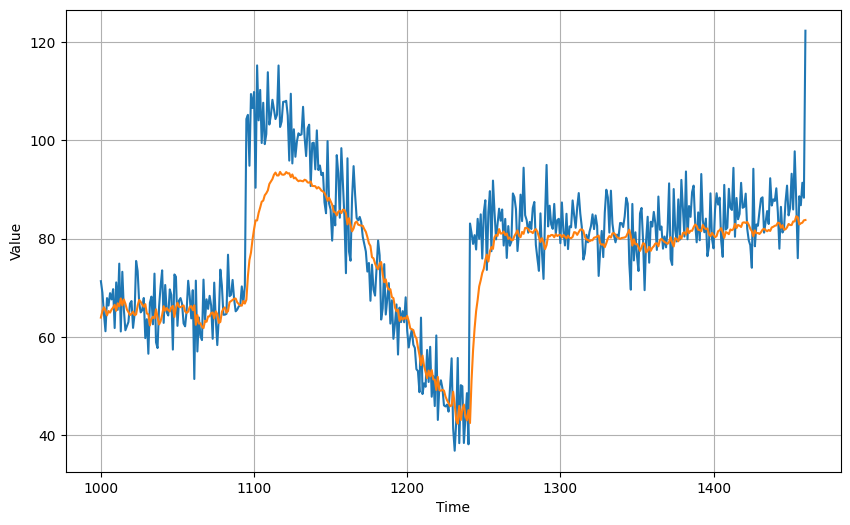

In [25]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))


In [26]:
# Compute the MSE and MAE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

68.60156
5.9029155


##Including a Validation Set while Training

Back in the first course of this specialization, you saw how you can also monitor the performance of your model against a validation set while training. You can also do that for this lab.

First, you need to generate a val_set which are data windows and labels that your model can accept. You can simply reuse the windowed_dataset function for that and you can pass in the x_valid points to generate the windows.

In [27]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [28]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 85.2946 - mae: 85.7936 - val_loss: 16.0083 - val_mae: 16.5031
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.8746 - mae: 16.3682 - val_loss: 25.2493 - val_mae: 25.7475
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.4474 - mae: 9.9351 - val_loss: 17.9307 - val_mae: 18.4262
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4312 - mae: 7.9159 - val_loss: 15.3849 - val_mae: 15.8771
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9389 - mae: 7.4187 - val_loss: 13.6085 - val_mae: 14.1013
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6544 - mae: 7.1374 - val_loss: 12.6864 - val_mae: 13.1749
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4203 - mae: 6.8999 - val_loss: 12.0716 - val_mae: 12.5602
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2259 - mae: 6.7047 - val_loss: 11.6714 - val_mae: 12.1585
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 

## Build a CNN+LSTM Model

Here is the model architecture you will be using. It is very similar to the last RNN you built but with the Conv1D layer at the input. One important argument here is the padding. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

Let's say you have a small time series window with these values: [1, 2, 3, 4, 5]. This means the value 1 is at t=0, 2 is at t=1, etc.
If you have a 1D kernel of size 3, then the first convolution will be for the values at [1, 2, 3] which are values for t=0 to t=2.
When you pass this to the first timestep of the LSTM after the convolution, it means that the value at t=0 of the LSTM depends on t=1 and t=2 which are values into the future.
For time series data, you want computations to only rely on current and previous time steps.
One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: [0, 0, 1, 2, 3, 4, 5]. 1 is still at t=0 and two zeroes are prepended to simulate values in the past.
This way, the first stride will be at [0, 0, 1] and this does not contain any future values when it is passed on to subsequent layers.
The Conv1D layer does this kind of padding by setting padding=causal and you'll see that below.

In [29]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 20, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 20, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,369 (259.25 KB)

 Trainable params: 66,369 (259.25 KB)

 Non-trainable params: 0 (0.00 B)

##Tune the Learning Rate

In the previous labs, you are using different models for tuning and training. That is a valid approach but you can also use the same model for both. Before tuning, you can use the get_weights() method so you can reset it later.

In [30]:
# Get initial weights
init_weights = model.get_weights()

In [32]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 125.8704 - learning_rate: 1.0000e-08
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 40.3954 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.5212 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.2062 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.1238 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.6993 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.3392 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.6091 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.1498 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.7859 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

(1e-08, 0.001, 0.0, 50.0)

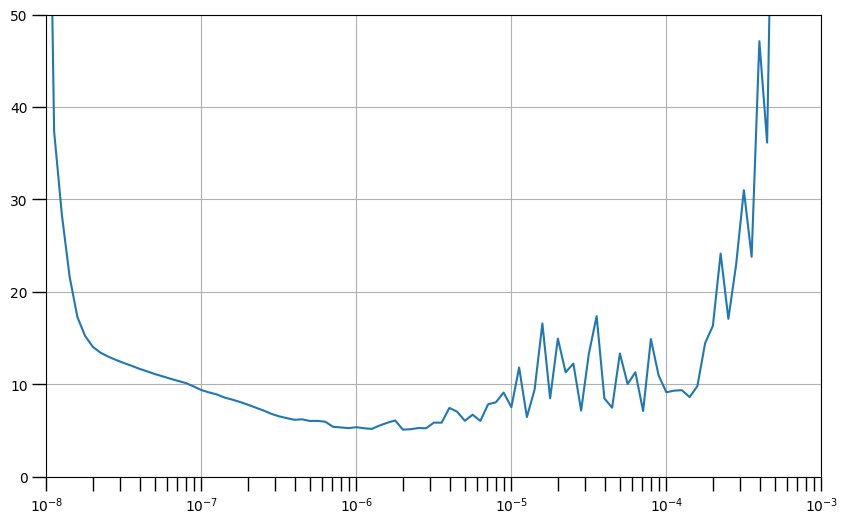

In [33]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

##Train the Model

To reset the weights, you can simply call the set_weights() and pass in the saved weights from earlier.

In [34]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [35]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [36]:
# Train the model
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 81.3841 - mae: 81.8827
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.4974 - mae: 15.9867
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.8293 - mae: 12.3098
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.0331 - mae: 11.5123
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.5263 - mae: 11.0074
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.1951 - mae: 10.6786
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8692 - mae: 10.3500
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3932 - mae: 9.8765
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1445 - mae: 9.6296
Epoch 10/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9610 - mae: 9.4457
Epoch 11/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7217 - mae: 9.2063
Epoch 12/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5392 - mae: 9.0229
Epoch 13/500
31/31 ━━━━━

Training can be a bit unstable especially as the weights start to converge so you may want to visualize it to see if it is still trending down. The earlier epochs might dominate the graph so it's also good to zoom in on the later parts of training to properly observe the parameters. The code below visualizes the mae and loss for all epochs, and also zooms in at the last 80%.

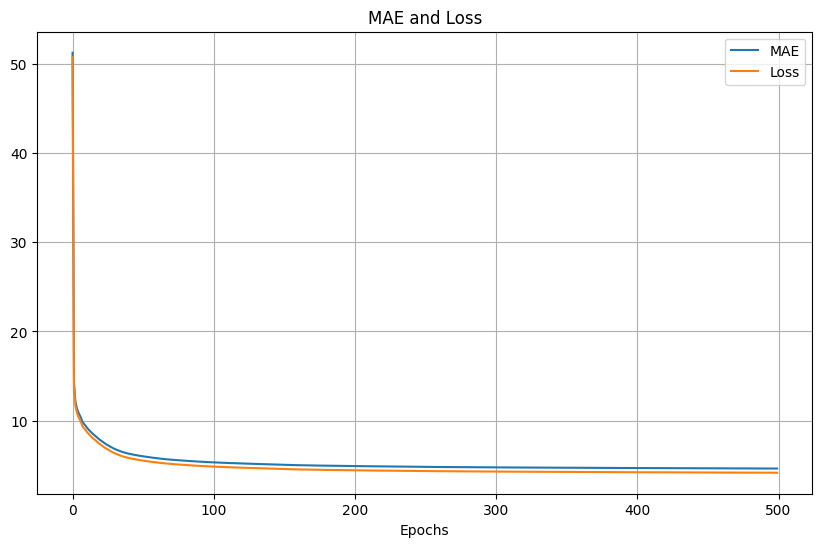

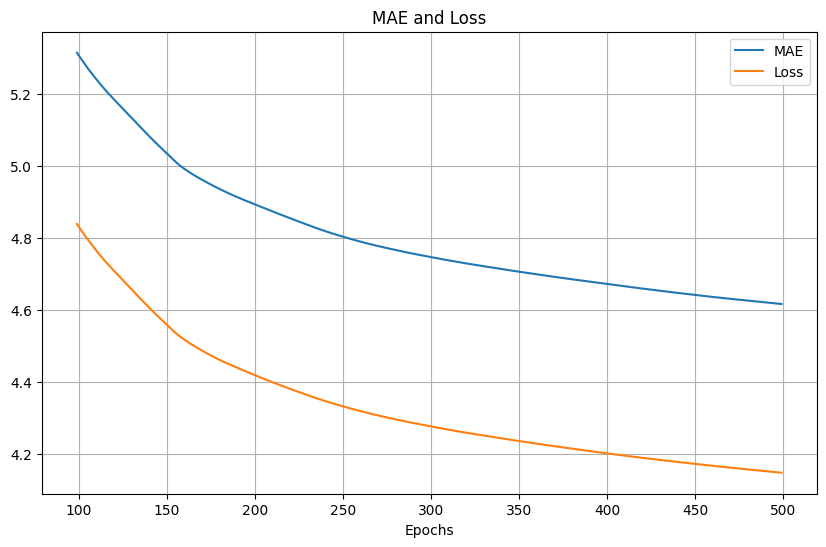

In [40]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x= epochs,
    y= (mae, loss),
    title='MAE and Loss',
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

##Model Prediction

Once training is done, you can generate the model predictions and plot them against the validation set.

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


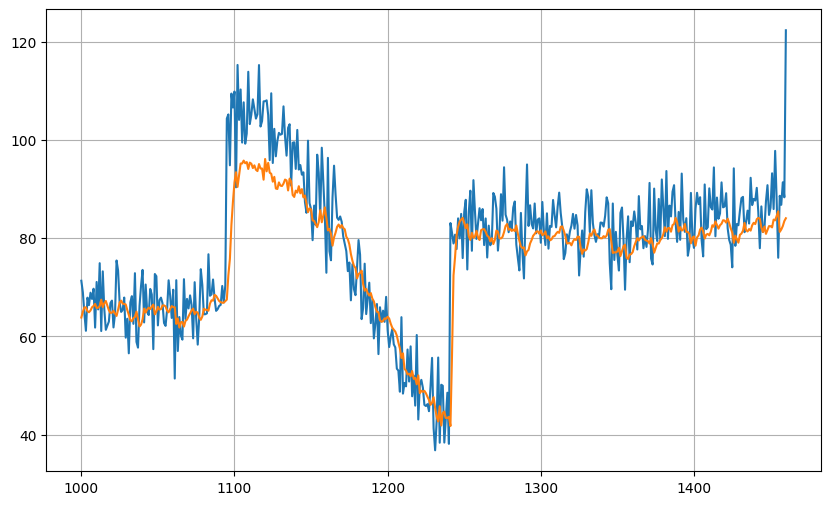

In [41]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [42]:
## Compute the MAE and MSE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

58.77495
5.5985956
